# <font style="color: rgb(0,0,0);">Joined Model</font> <font style="color: rgb(190,138,67);">Relevance Comparison</font>

In [200]:
# imports
import numpy as np
import xarray as xr
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from tqdm.notebook import tqdm

inferno = cm.get_cmap('inferno', 256)
newcolors = inferno(np.linspace(0, 1, 256))
revinferno = ListedColormap(np.flip(newcolors,axis=0))

In [4]:
from A_helper_functions import *

In [5]:
def info(dataset):
    print(f'{dataset.dtype} {dataset.shape} data range: {np.min(dataset)} - {np.max(dataset)}')

In [6]:
# A Result
ISRU_data = xr.open_dataarray("maps/ISRU_COST_GLOBAL.nc").data
info(ISRU_data)

float32 (13680, 27360) data range: 17054.625 - 157718.5


In [8]:
# B Results
spent_fuel_NRHO_1_25 = xr.open_dataarray("maps/spent_fuel_NRHO_1_25.nc").data
spent_fuel_NRHO_1_5  = xr.open_dataarray("maps/spent_fuel_NRHO_1_5.nc").data
info(spent_fuel_NRHO_1_25)
info(spent_fuel_NRHO_1_5)

float32 (11520, 23040) data range: 3.1104774475097656 - 3.199880599975586
float32 (11520, 23040) data range: 2.693203926086426 - 2.75943660736084


In [9]:
# match resolution to be able to combine data
ISRU_data_resized = cv2.resize(ISRU_data, dsize=(23040,11520), interpolation=cv2.INTER_NEAREST)
info(ISRU_data_resized) 

float32 (11520, 23040) data range: 17054.625 - 157718.5


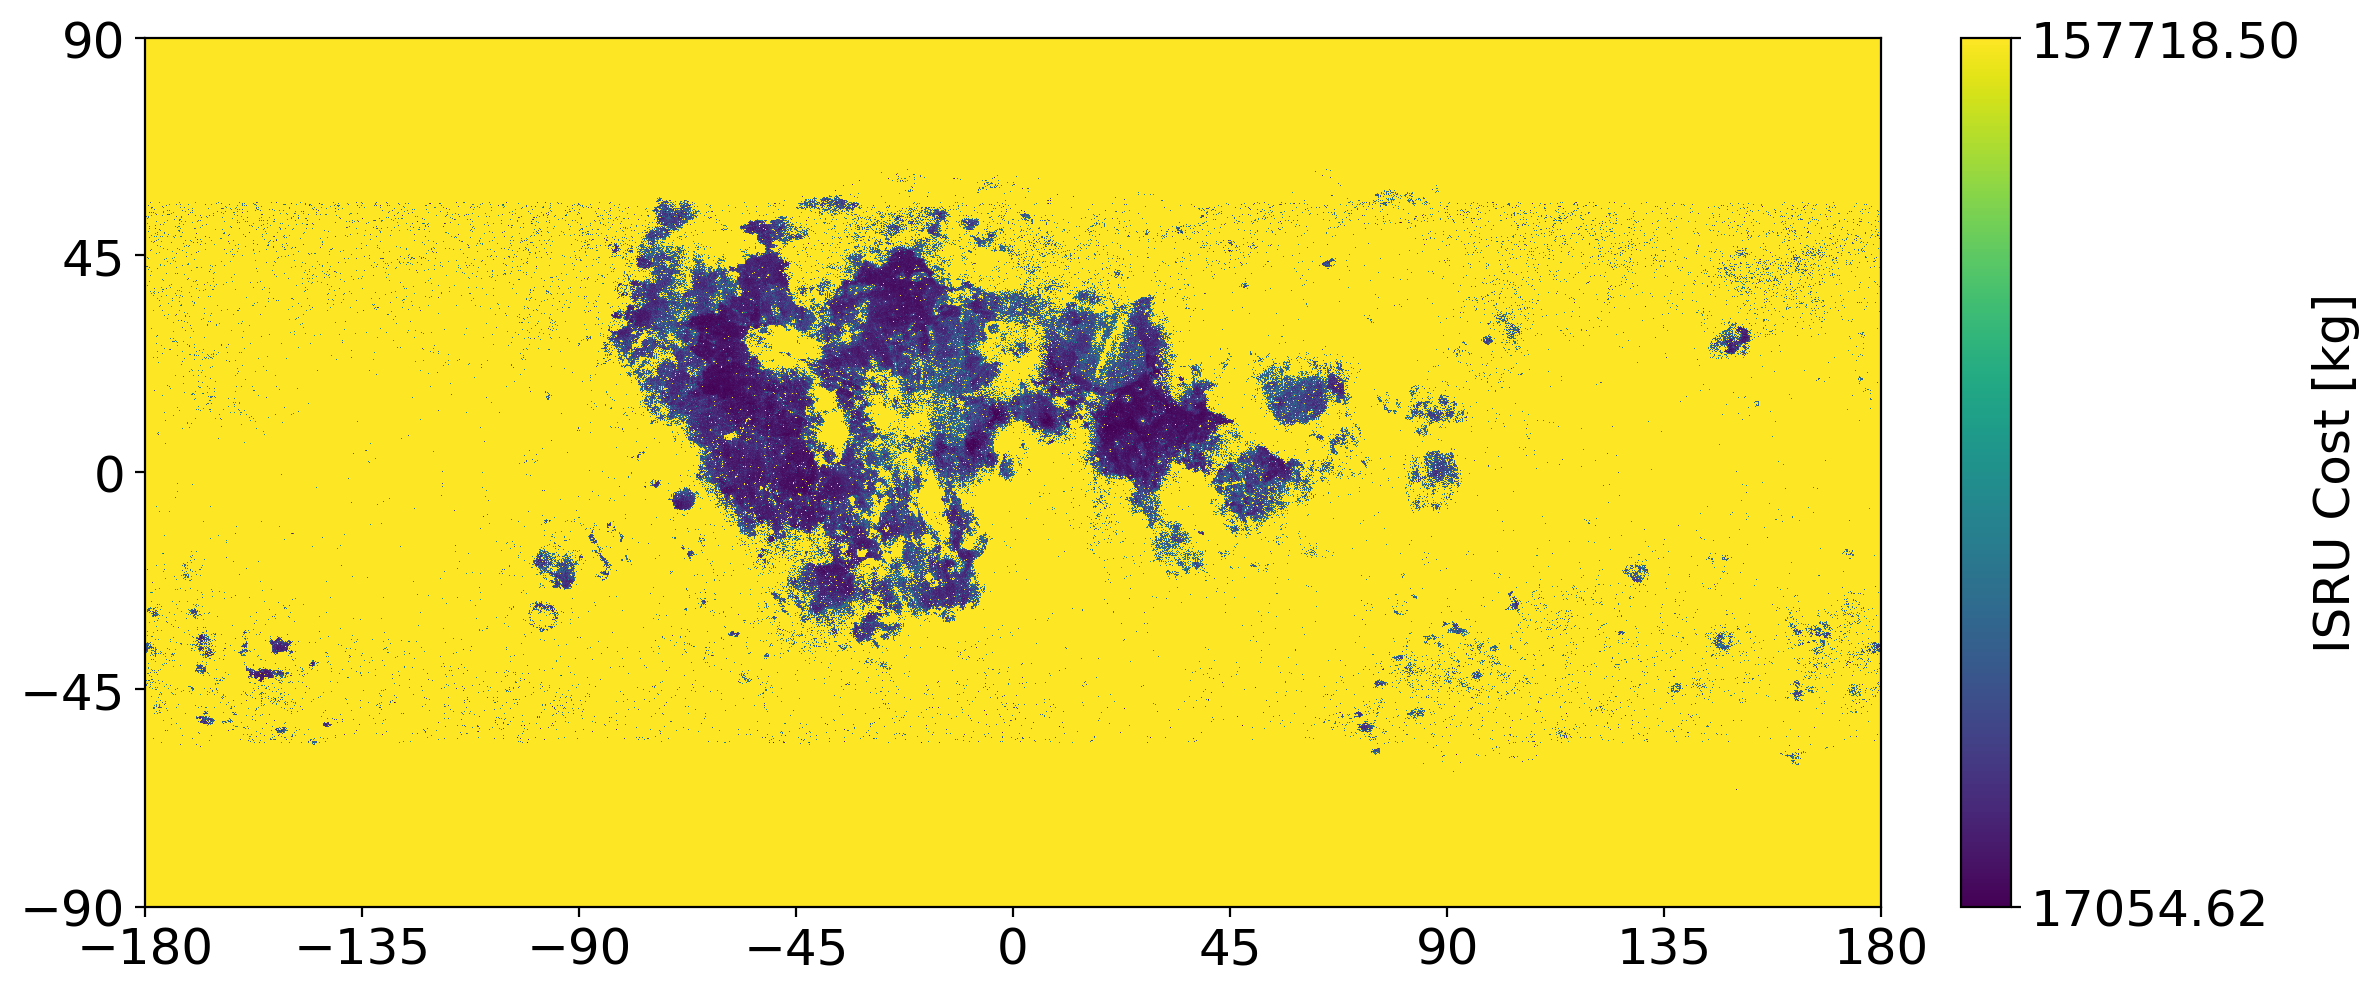

In [10]:
# visual inspection of downsampled vs original data
plot_map(ISRU_data_resized,1,'ISRU Cost [kg]',(-90,90),(-180,180),i_steps=[],silent=True,labelsize=18)

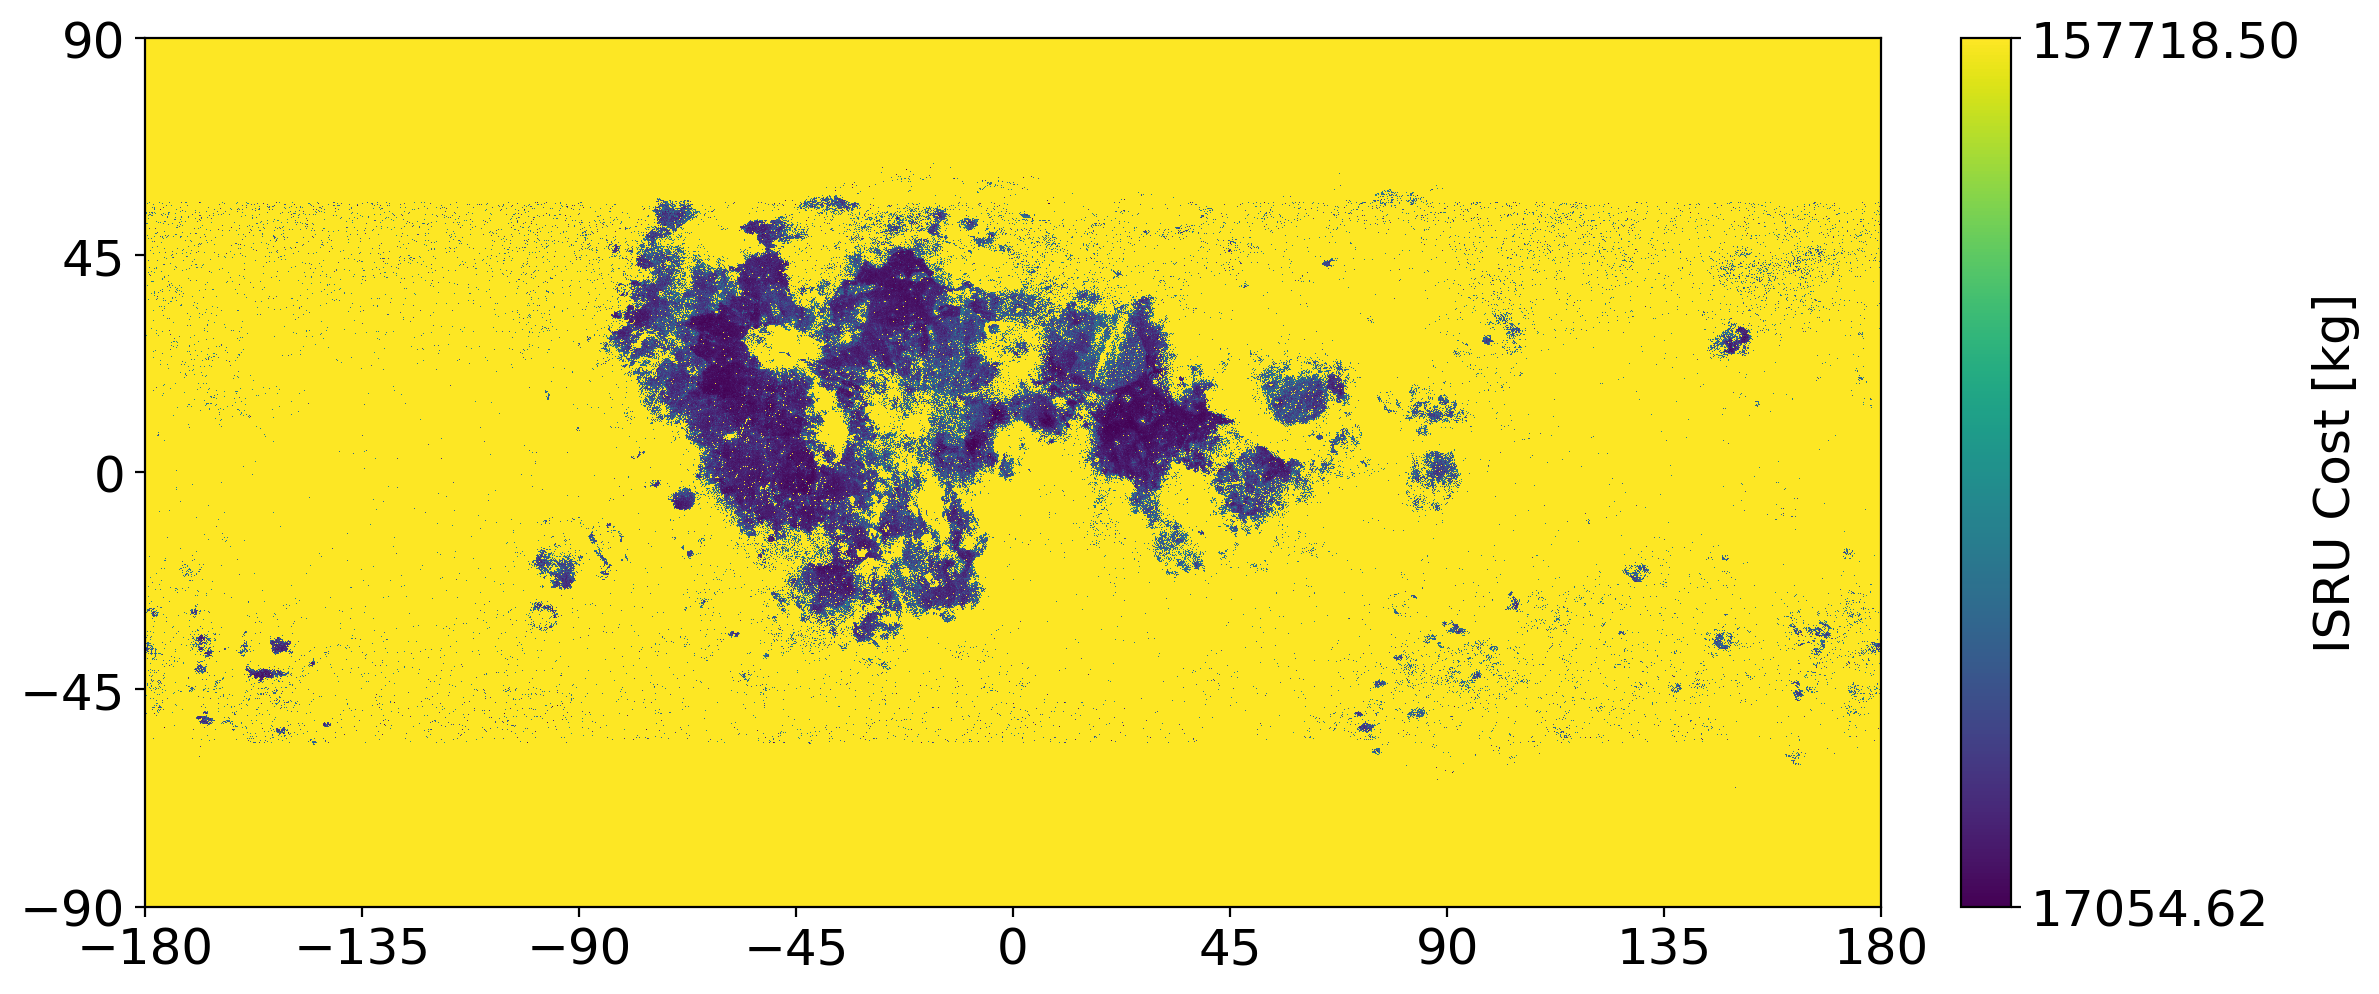

In [11]:
plot_map(ISRU_data,1,'ISRU Cost [kg]',(-90,90),(-180,180),i_steps=[],silent=True,labelsize=18)

## Combined Model

### SIMPLE
assuming all spend fuel masses to be cost

In [12]:
# cost_per_kg_payload = (used_O2 + used_H2) / payload
# Total costs = ISRU_costs + t [years] * m_payload_per_year * cost_per_kg_payload

In [13]:
m_payload_per_year = 23.9 * 1000

def total_costs_simple_1_25(years):
    res = ISRU_data_resized + years * m_payload_per_year * spent_fuel_NRHO_1_25
    return res

def total_costs_simple_1_5(years):
    res = ISRU_data_resized + years * m_payload_per_year * spent_fuel_NRHO_1_5
    return res

In [106]:
Total_cost_map_simple_1_25 = total_costs_simple_1_25(100)

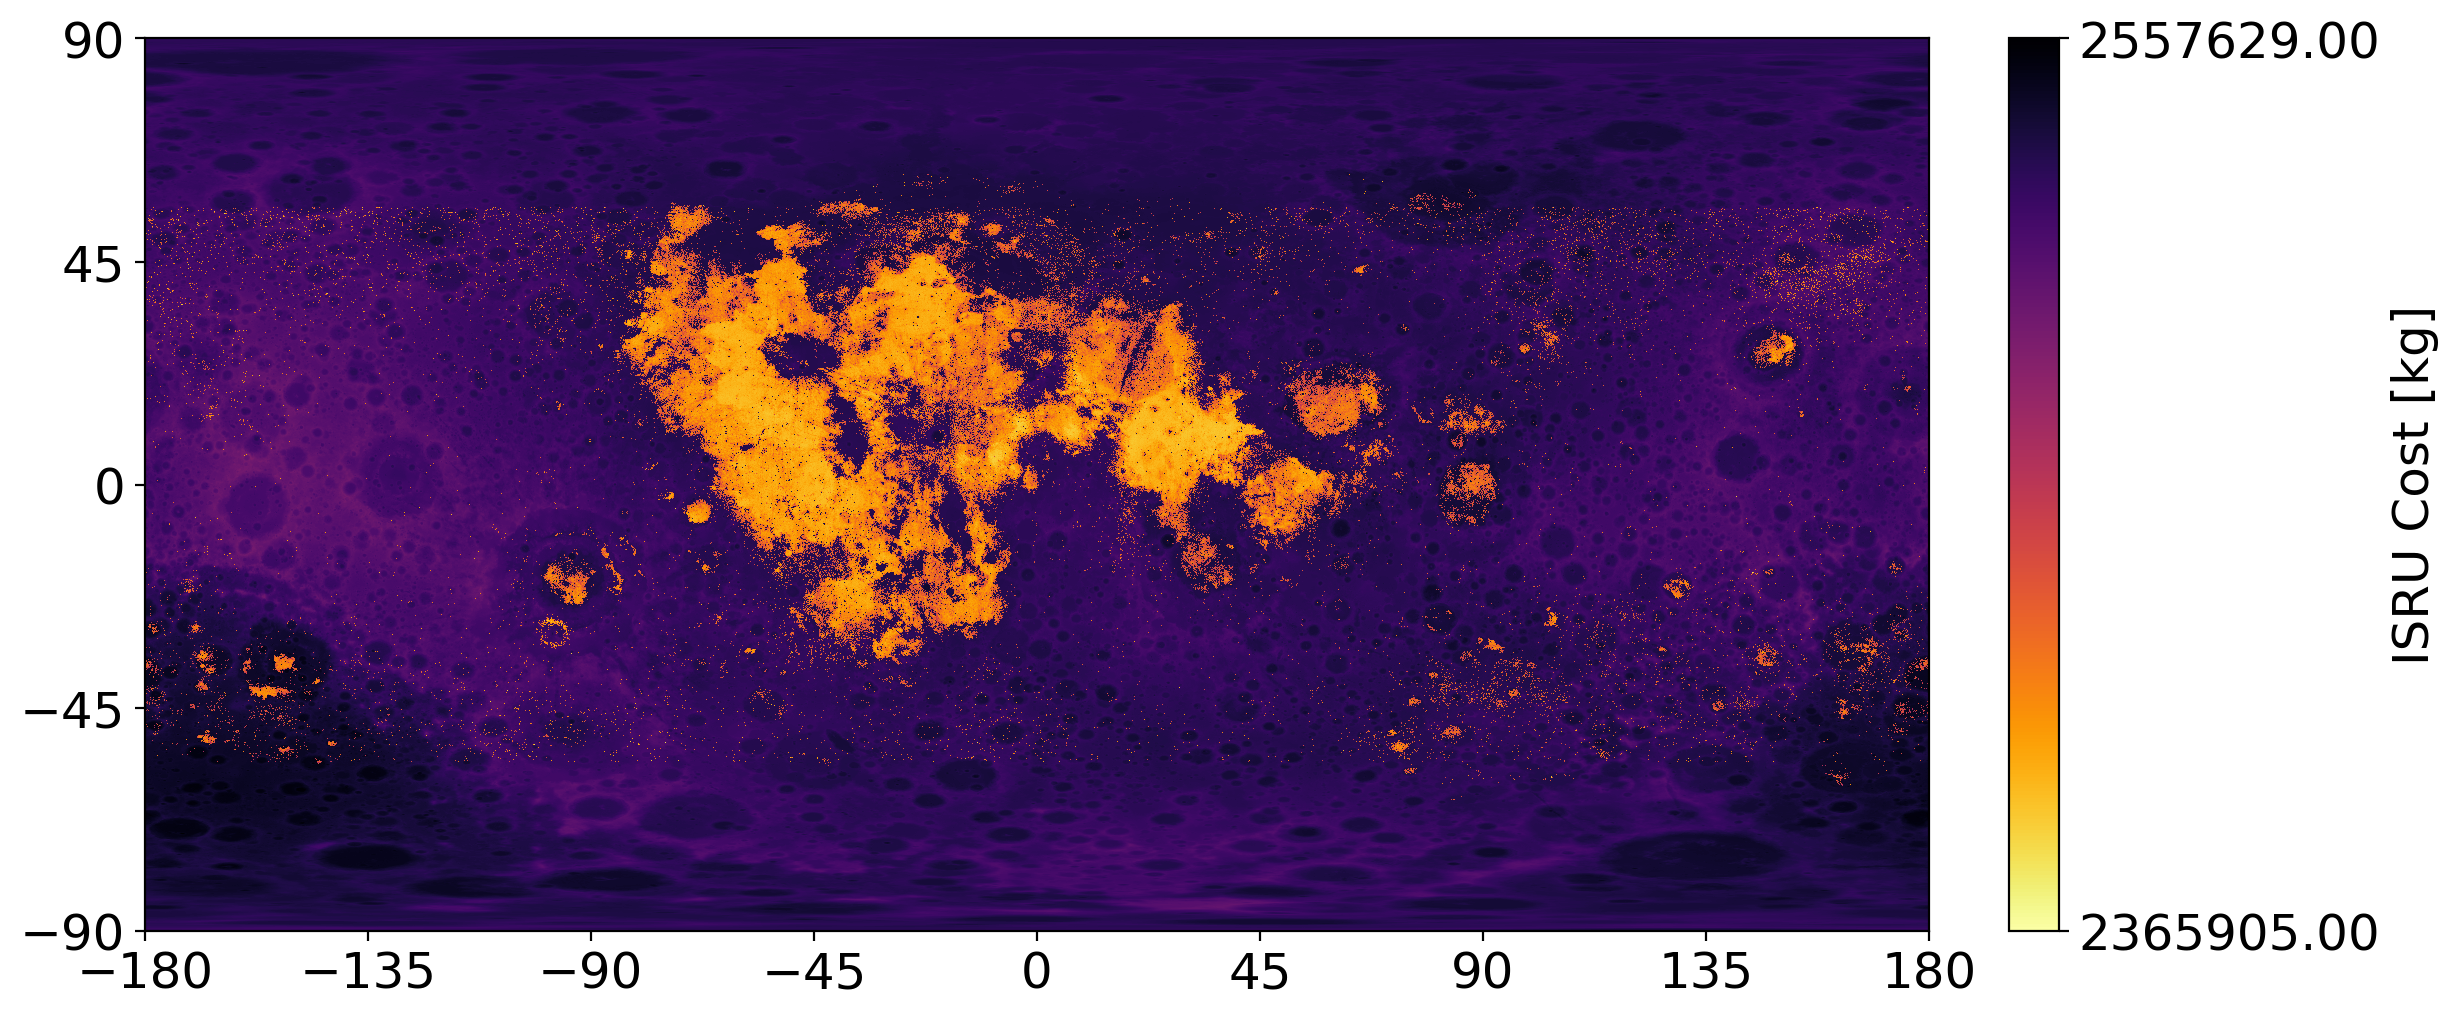

In [107]:
plot_map(Total_cost_map_simple_1_25,1,'ISRU Cost [kg]',(-90,90),(-180,180),cmap=revinferno,i_steps=[],silent=True,labelsize=18)

In [108]:
Total_cost_map_simple_1_5 = total_costs_simple_1_5(100)

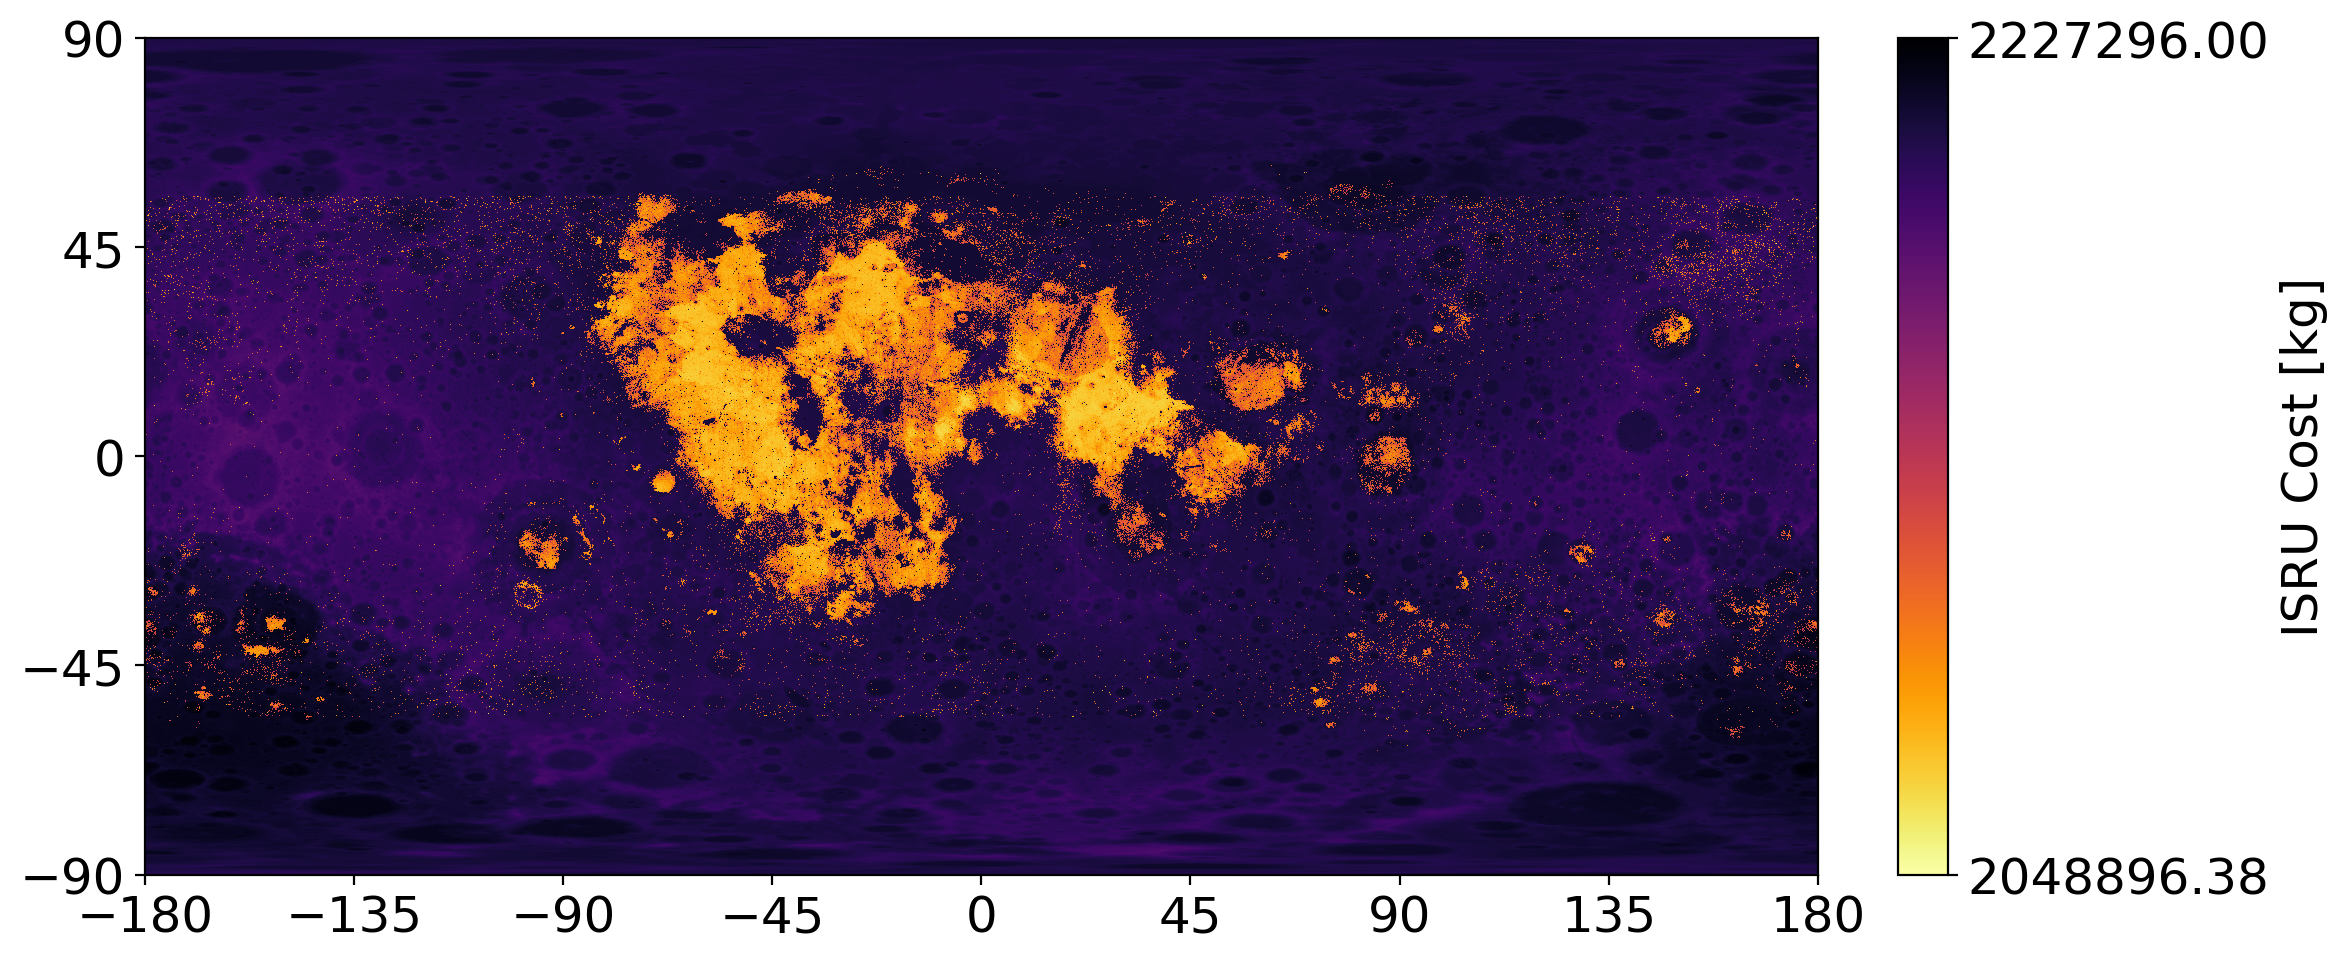

In [109]:
plot_map(Total_cost_map_simple_1_5,1,'ISRU Cost [kg]',(-90,90),(-180,180),cmap=revinferno,i_steps=[],silent=True,labelsize=18)

### Result - SIMPLE

with 1.25 exchange ratio (R = 9.364)
- even after 10 years of operation the transport costs did not change the landscape of preferred areas
- significant influence visible at around 100 years (still mare region optimal)

with 1.5 exchange ratio (R = 11.724)
- transport influence even less pronounced than with 1.25 exchange ratio (due to lower level of costs)

## ADVANCED
assuming: cost = H2 fuel mass cost + extra mass for ISRU to match higher O2 demand

In [18]:
# advanced - assuming H2 fuel mass cost + extra mass for ISRU to match higher O2 demand

# cost_per_kg_payload = used_H2 + additional_ISRU_mass(used_O2_per_year)
# Total costs = ISRU_costs + t [years] * m_payload_per_year * cost_per_kg_payload

In [34]:
# ISRU mass per additional kg of Oxygen per year
ISRU_mass_per_kg = ISRU_data_resized / (23.9 * 1000)

In [127]:
m_payload_per_year = 7.5 * 1000 # [kg]
m_ISRU_base_prod_per_year = 23.9 * 1000 # [kg]

of_ratio = 3
O2_factor = (of_ratio/(of_ratio+1))
H2_factor = (1/(of_ratio+1))

def total_costs_advanced_1_25(years, return_splits=False):
    spend_O2_per_year = m_payload_per_year * spent_fuel_NRHO_1_25 * O2_factor
    m_ISRU_additional = spend_O2_per_year + m_payload_per_year - m_ISRU_base_prod_per_year
    fix_costs_additionally = ISRU_cost_per_kg * m_ISRU_additional
    
    dynamic_costs_H2 = years * m_payload_per_year * spent_fuel_NRHO_1_25 * H2_factor
    
    res = ISRU_data_resized + fix_costs_additionally + dynamic_costs_H2
    
    if return_splits:
        return ISRU_data_resized, fix_costs_additionally, dynamic_costs_H2
    else:
        return res

def total_costs_advanced_1_5(years, return_splits=False):
    spend_O2_per_year = m_payload_per_year * spent_fuel_NRHO_1_5 * O2_factor
    m_ISRU_additional = spend_O2_per_year + m_payload_per_year - m_ISRU_base_prod_per_year
    fix_costs_additionally = ISRU_cost_per_kg * m_ISRU_additional
    
    dynamic_costs_H2 = years * m_payload_per_year * spent_fuel_NRHO_1_25 * H2_factor
    
    res = ISRU_data_resized + fix_costs_additionally + dynamic_costs_H2
    
    if return_splits:
        return ISRU_data_resized + fix_costs_additionally, dynamic_costs_H2
    else:
        return res

In [102]:
Total_cost_map_advanced_1_25 = total_costs_advanced_1_25(100)

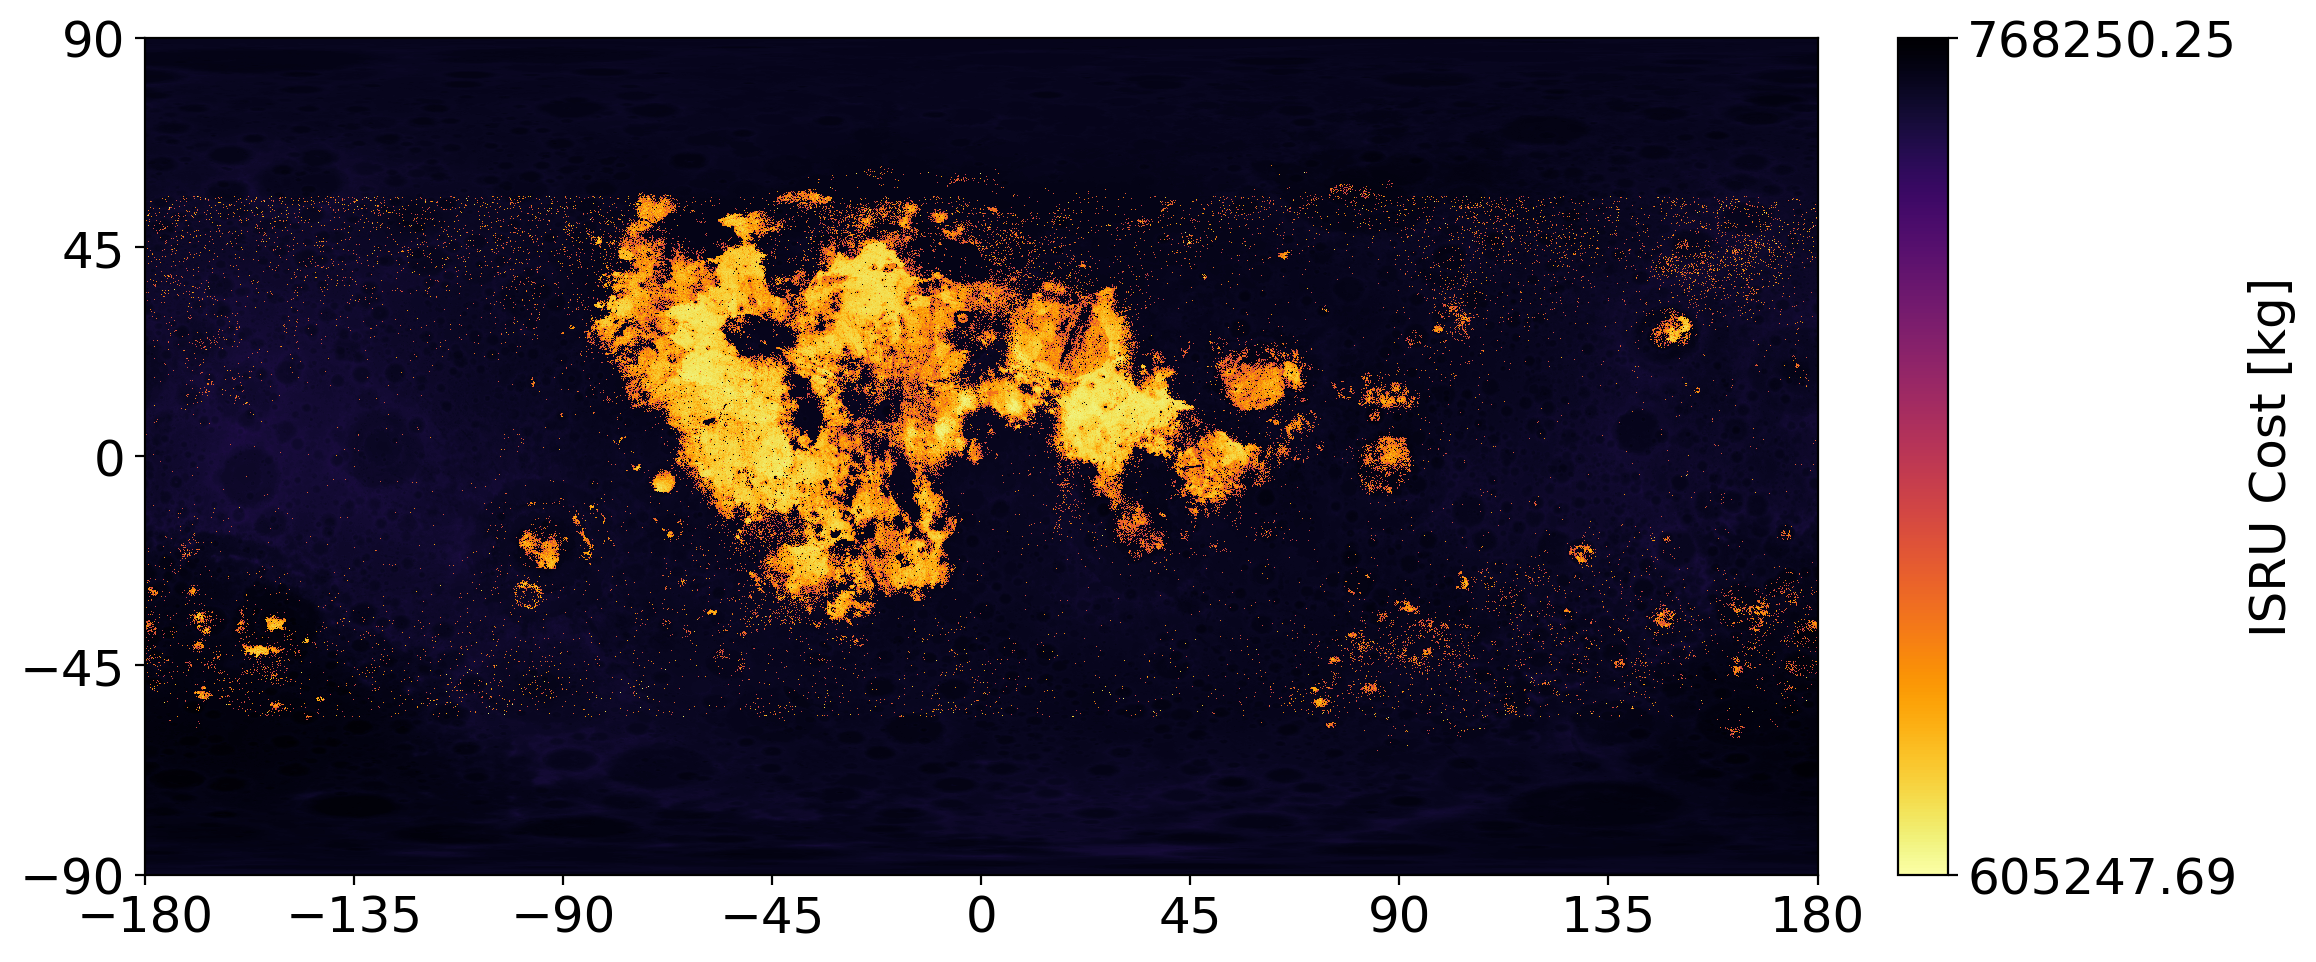

In [103]:
plot_map(Total_cost_map_advanced_1_25,1,'ISRU Cost [kg]',(-90,90),(-180,180),cmap=revinferno,i_steps=[],silent=True,labelsize=18)

In [104]:
Total_cost_map_advanced_1_5 = total_costs_advanced_1_5(100)

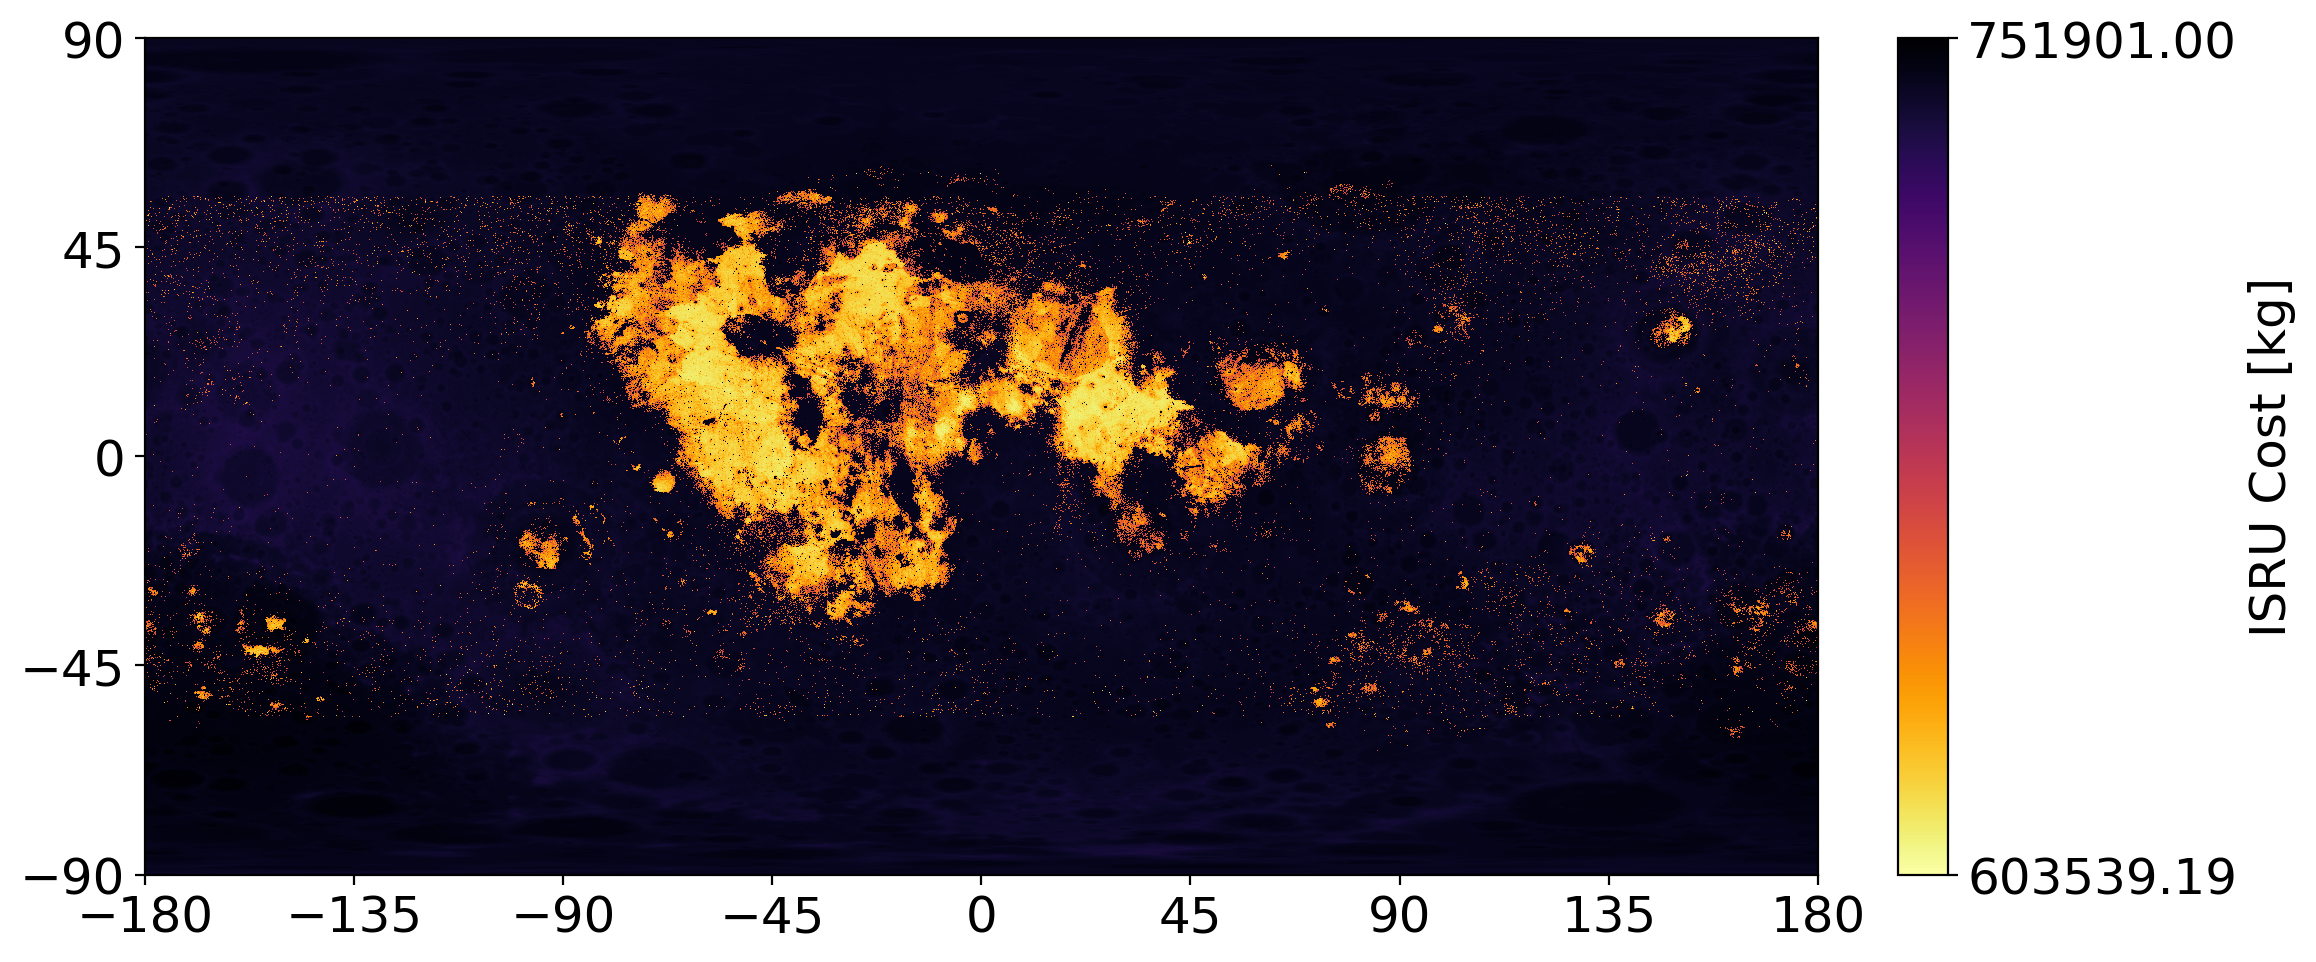

In [105]:
plot_map(Total_cost_map_advanced_1_5,1,'ISRU Cost [kg]',(-90,90),(-180,180),cmap=revinferno,i_steps=[],silent=True,labelsize=18)

In [148]:
x = np.array([0,1,5,10,50,100,500,1000])

fix_cost_min = np.zeros(x.shape) # ISRU cost + additional ISRU cost
fix_cost_max = np.zeros(x.shape)

dyn_cost_min = np.zeros(x.shape) # dynamic costs H2
dyn_cost_max = np.zeros(x.shape)

with tqdm(total=len(x)) as pbar: 
    for i, year in enumerate(x):
        fix_cost , dyn_cost = total_costs_advanced_1_5(year, return_splits=True)
        fix_cost_min[i] = np.min(fix_cost)
        fix_cost_max[i] = np.max(fix_cost)
        dyn_cost_min[i] = np.min(dyn_cost)
        dyn_cost_max[i] = np.max(dyn_cost)
        pbar.update(1)

  0%|          | 0/8 [00:00<?, ?it/s]

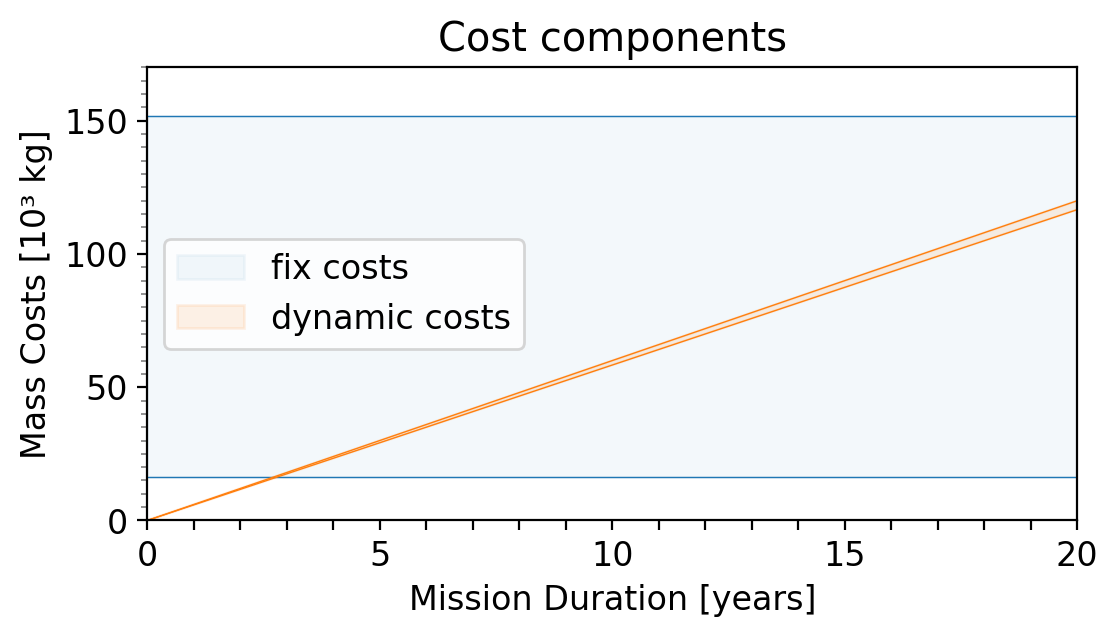

In [234]:
plt.figure(figsize=(6,3), dpi=200)
plt.title("Cost components")
divider = 1000

plt.plot(x,fix_cost_min/divider,color='tab:blue',linewidth=0.5)
plt.plot(x,fix_cost_max/divider,color='tab:blue',linewidth=0.5)
plt.axhspan(fix_cost_min[0]/divider, fix_cost_max[0]/divider, color='tab:blue', alpha=0.05, label='fix costs')

plt.plot(x,dyn_cost_min/divider,color='tab:orange',linewidth=0.5)
plt.plot(x,dyn_cost_max/divider,color='tab:orange',linewidth=0.5)
plt.fill_between(x,dyn_cost_min/divider, dyn_cost_max/divider,color='tab:orange',alpha=0.1, label='dynamic costs')

plt.ylim(0,170)
plt.xlim(0,20)
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(5))
for i, label in enumerate(ax.xaxis.get_ticklabels()):
    if i % 5 != 1:
        label.set_visible(False)
ax.tick_params(axis='y', which='minor', colors='0.5'),

plt.ylabel("Mass Costs [10³ kg]")
plt.xlabel("Mission Duration [years]")
plt.show()

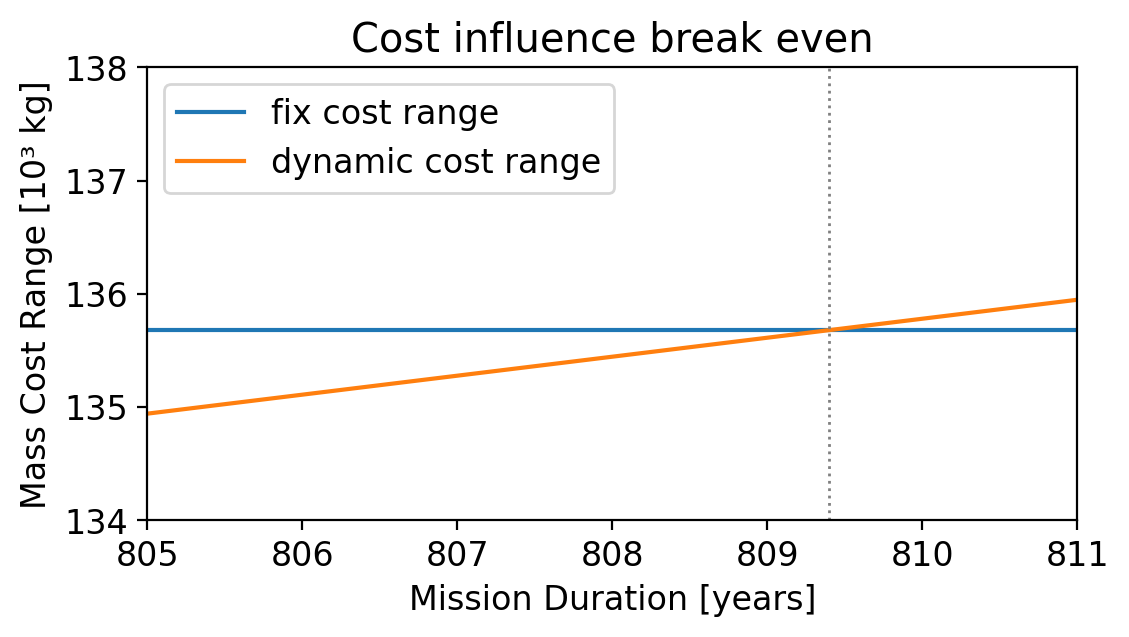

In [276]:
divider = 1000

plt.figure(figsize=(6,3), dpi=200)
plt.title("Cost influence break even")

plt.plot(x,(fix_cost_max - fix_cost_min)/divider,label='fix cost range') # ISRU range
plt.plot(x,(dyn_cost_max - dyn_cost_min)/divider,label='dynamic cost range') # Transport range

plt.axvline(x=809.4 ,linewidth=1, color='0.5',linestyle=":")

#plt.xlim(0,1000)
#plt.xlim(0,20)
plt.ylim(134,138)
plt.xlim(805,811)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.legend()
plt.ylabel("Mass Cost Range [10³ kg]")
plt.xlabel("Mission Duration [years]")
plt.show()
# after 810 years it has a higher influence range